In [32]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from pyod.models import auto_encoder, vae, anogan
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from pyod.utils.data import evaluate_print
import matplotlib.pyplot as plt
from pyod.utils.example import visualize
from sklearn.decomposition import PCA

In [34]:
# Load and preview the training dataset
train_data = pd.read_csv('UNSW_NB15_training-set.csv')
train_data.head()

# Load and preview the testing dataset
test_data = pd.read_csv('UNSW_NB15_testing-set.csv')
test_data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [35]:
# Calculate and print the contamination rate in the training and testing data
tmp = train_data.where(train_data['attack_cat'] == 'Normal').dropna()
train_contamination = 1 - len(tmp) / len(train_data)
print('Train contamination:', train_contamination)

tmp = test_data.where(test_data['attack_cat'] == 'Normal').dropna()
test_contamination = 1 - len(tmp) / len(test_data)
print('Test contamination:', test_contamination, '\n')

# Adjust train and test contamination if they exceed 50%
if train_contamination > 0.5:
    print(f'Train contamination is too high: {train_contamination}')
    train_contamination = 1 - train_contamination
    print(f'New train contamination: {train_contamination}')

if test_contamination > 0.5:
    print(f'Test contamination is too high: {test_contamination}')
    test_contamination = 1 - test_contamination
    print(f'New test contamination: {test_contamination}')

Train contamination: 0.6806223302022916
Test contamination: 0.5506000097167565 

Train contamination is too high: 0.6806223302022916
New train contamination: 0.31937766979770843
Test contamination is too high: 0.5506000097167565
New test contamination: 0.4493999902832435


In [36]:
# Combine training and testing datasets, dropping 'id' and 'attack_cat' columns
combined_data = pd.concat([train_data, test_data]).drop(['id', 'attack_cat'], axis=1).dropna()
combined_data.head()
combined_data.info()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  object 
 2   service            257673 non-null  object 
 3   state              257673 non-null  object 
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  dinpkt  

In [37]:
# Encode categorical columns 'proto', 'service', and 'state' into numerical values using LabelEncoder
le = LabelEncoder()

combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

combined_data.head()
combined_data.info()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  int32  
 2   service            257673 non-null  int32  
 3   state              257673 non-null  int32  
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  dinpkt  

In [38]:
# Separate features (X_combined) and target labels (y_combined) from the dataset
# 'label' is dropped from features and target labels are inverted (1 -> 0, 0 -> 1) 
# due to excessive contamination
X_combined = combined_data.drop(['label'], axis=1)
y_combined = 1 - combined_data['label']

X_combined
y_combined

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,1,1,0,0,0,1,1,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,1,1,2,0,0,0,1,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,2,1,1,3,0,0,0,2,6,0
3,1.681642,113,3,4,12,12,628,770,13.677108,62,...,2,1,1,3,1,1,0,2,1,0
4,0.449454,113,0,4,10,6,534,268,33.373826,254,...,2,2,1,40,0,0,0,2,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,119,0,5,2,0,104,0,200000.005100,254,...,2,1,1,2,0,0,0,2,1,0
82328,1.106101,113,0,4,20,8,18062,354,24.410067,254,...,2,1,1,1,0,0,0,3,2,0
82329,0.000000,6,0,5,1,0,46,0,0.000000,0,...,1,1,1,1,0,0,0,1,1,1
82330,0.000000,6,0,5,1,0,46,0,0.000000,0,...,1,1,1,1,0,0,0,1,1,1


0        1
1        1
2        1
3        1
4        1
        ..
82327    1
82328    1
82329    1
82330    1
82331    1
Name: label, Length: 257673, dtype: int64

In [39]:
# Split the combined dataset back into training and testing sets
X_train = X_combined.iloc[:len(train_data)]
X_test = X_combined.iloc[len(train_data):]

# Split the target labels into training and testing sets
y_train = y_combined.iloc[:len(train_data)]
y_test = y_combined.iloc[len(train_data):]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((175341, 42), (82332, 42), (175341,), (82332,))

In [40]:
# Initialize the GAN with specified parameters
gan = anogan.AnoGAN(contamination=train_contamination,
                    activation_hidden='relu',
                    preprocessing=True,
                    epochs=1000,
                    learning_rate=0.00001,
                    learning_rate_query=0.00001,
                    batch_size=32,
                    dropout_rate=0.1,
                    verbose=1)

# Train the GAN on the training data (only the first 5000 samples)
gan.fit(X_train[:5000])

Train iter:100
Train iter:200
Train iter:300
Train iter:400
Train iter:500
Train iter:600
Train iter:700
Train iter:800
Train iter:900
query sample 1 / 5000
iter: 0
query sample 2 / 5000
iter: 0
query sample 3 / 5000
iter: 0
query sample 4 / 5000
iter: 0
query sample 5 / 5000
iter: 0
query sample 6 / 5000
iter: 0
query sample 7 / 5000
iter: 0
query sample 8 / 5000
iter: 0
query sample 9 / 5000
iter: 0
query sample 10 / 5000
iter: 0
query sample 11 / 5000
iter: 0
query sample 12 / 5000
iter: 0
query sample 13 / 5000
iter: 0
query sample 14 / 5000
iter: 0
query sample 15 / 5000
iter: 0
query sample 16 / 5000
iter: 0
query sample 17 / 5000
iter: 0
query sample 18 / 5000
iter: 0
query sample 19 / 5000
iter: 0
query sample 20 / 5000
iter: 0
query sample 21 / 5000
iter: 0
query sample 22 / 5000
iter: 0
query sample 23 / 5000
iter: 0
query sample 24 / 5000
iter: 0
query sample 25 / 5000
iter: 0
query sample 26 / 5000
iter: 0
query sample 27 / 5000
iter: 0
query sample 28 / 5000
iter: 0
query 

AnoGAN(D_layers=[20, 10, 5], G_layers=[20, 10, 3, 10, 20],
    activation_hidden='relu', batch_size=32,
    contamination=0.31937766979770843, dropout_rate=0.1, epochs=1000,
    epochs_query=20, index_D_layer_for_recon_error=1, latent_dim_G=2,
    learning_rate=1e-05, learning_rate_query=1e-05, output_activation=None,
    preprocessing=True, verbose=1)

In [41]:
# Predict anomalies on the test set using the trained GAN (only the first 1000 samples)
y_pred = gan.predict(X_test[:1000])
y_scores = gan.decision_function(X_test[:1000]) # Get first 1000 anomaly scores
y_test = y_test[:1000] # Get first 1000 true labels

# Set threshold based on contamination level in test data
threshold = np.percentile(y_scores, 100 * (1 - test_contamination))
y_pred = y_scores > threshold # Classify based on the threshold

# Print confusion matrix, classification report, and ROC curve
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
evaluate_print('GAN', y_test, y_scores)

query sample 1 / 1000
iter: 0
query sample 2 / 1000
iter: 0
query sample 3 / 1000
iter: 0
query sample 4 / 1000
iter: 0
query sample 5 / 1000
iter: 0
query sample 6 / 1000
iter: 0
query sample 7 / 1000
iter: 0
query sample 8 / 1000
iter: 0
query sample 9 / 1000
iter: 0
query sample 10 / 1000
iter: 0
query sample 11 / 1000
iter: 0
query sample 12 / 1000
iter: 0
query sample 13 / 1000
iter: 0
query sample 14 / 1000
iter: 0
query sample 15 / 1000
iter: 0
query sample 16 / 1000
iter: 0
query sample 17 / 1000
iter: 0
query sample 18 / 1000
iter: 0
query sample 19 / 1000
iter: 0
query sample 20 / 1000
iter: 0
query sample 21 / 1000
iter: 0
query sample 22 / 1000
iter: 0
query sample 23 / 1000
iter: 0
query sample 24 / 1000
iter: 0
query sample 25 / 1000
iter: 0
query sample 26 / 1000
iter: 0
query sample 27 / 1000
iter: 0
query sample 28 / 1000
iter: 0
query sample 29 / 1000
iter: 0
query sample 30 / 1000
iter: 0
query sample 31 / 1000
iter: 0
query sample 32 / 1000
iter: 0
query sample 33 /

<Figure size 640x480 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver Operating Characteristic (ROC) Curve')

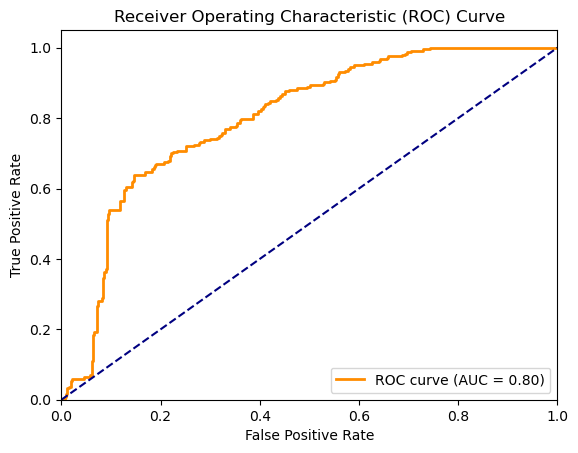

In [42]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})', linestyle='-', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

query sample 1 / 1000
iter: 0
query sample 2 / 1000
iter: 0
query sample 3 / 1000
iter: 0
query sample 4 / 1000
iter: 0
query sample 5 / 1000
iter: 0
query sample 6 / 1000
iter: 0
query sample 7 / 1000
iter: 0
query sample 8 / 1000
iter: 0
query sample 9 / 1000
iter: 0
query sample 10 / 1000
iter: 0
query sample 11 / 1000
iter: 0
query sample 12 / 1000
iter: 0
query sample 13 / 1000
iter: 0
query sample 14 / 1000
iter: 0
query sample 15 / 1000
iter: 0
query sample 16 / 1000
iter: 0
query sample 17 / 1000
iter: 0
query sample 18 / 1000
iter: 0
query sample 19 / 1000
iter: 0
query sample 20 / 1000
iter: 0
query sample 21 / 1000
iter: 0
query sample 22 / 1000
iter: 0
query sample 23 / 1000
iter: 0
query sample 24 / 1000
iter: 0
query sample 25 / 1000
iter: 0
query sample 26 / 1000
iter: 0
query sample 27 / 1000
iter: 0
query sample 28 / 1000
iter: 0
query sample 29 / 1000
iter: 0
query sample 30 / 1000
iter: 0
query sample 31 / 1000
iter: 0
query sample 32 / 1000
iter: 0
query sample 33 /

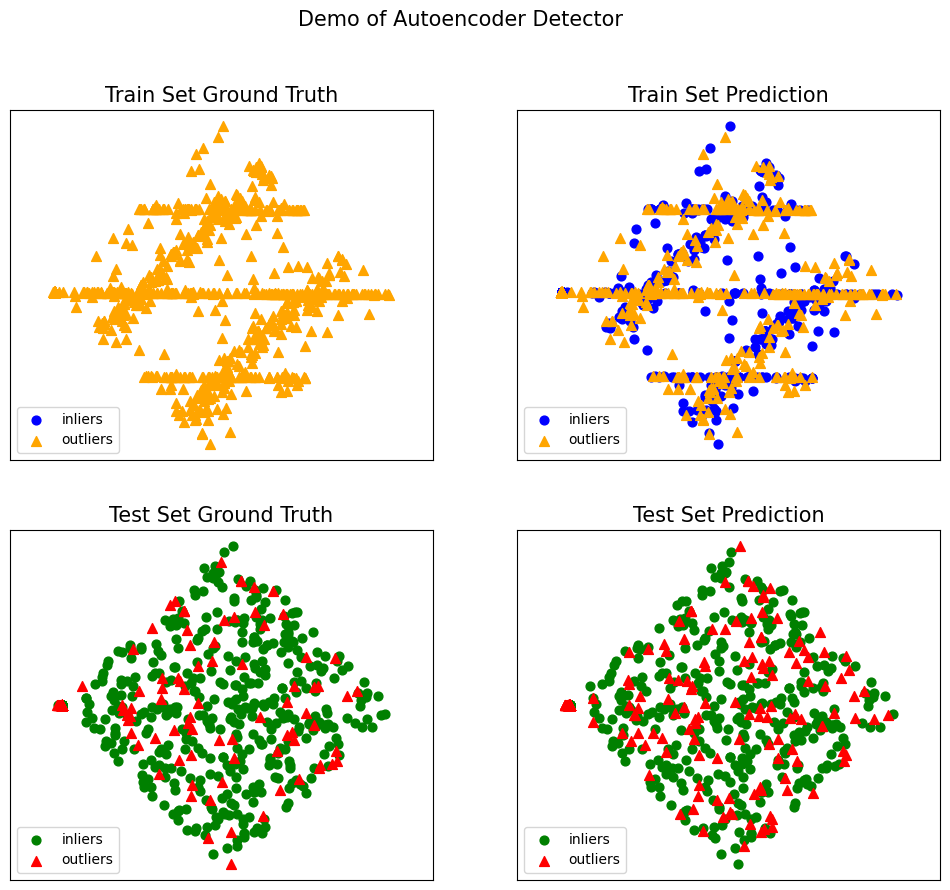

In [44]:
# Visualize the results using PCA
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train[:1000])
X_test_2d = pca.transform(X_test[:1000])

y_train_pred = gan.predict(X_train[:1000])

visualize('GAN', X_train_2d, y_train[:1000], X_test_2d, y_test, y_train_pred, y_pred, show_figure=True, save_figure=False)